# Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import re

In [3]:
PATH = "data/demand-forecasting/"

# Helper Functions

In [4]:
def add_datepart(df, fldname, drop=True, time=False):
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [1]:
def rmse(y_true, y_pred):
    return math.sqrt(((y_pred-y_true)**2).mean())

In [5]:
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)

In [6]:
def print_scores(pred,label):
    rmse = np.sqrt(mean_squared_error(pred,label))
    mae = mean_absolute_error(pred,label)
    smape_score = smape(label, pred)
    
    print('RMSE: ' + str(rmse))
    print('MAE: ' + str(mae))
    print('SMAPE: ' + str(smape_score))

In [7]:
def plot_preds(pred,label):  
    
    plt.xlabel('Actual Y ')
    plt.ylabel('Predicted Y')
    
    x = np.linspace(0.0, 200.0)
    y = x
    plt.plot(x, y, 'r')
    
    plt.scatter(label,predictions, alpha=0.2)
    plt.show()

# Pre-Process Data

In [8]:
train = pd.read_csv(f'{PATH}train.csv', parse_dates=['date'])
test = pd.read_csv(f'{PATH}test.csv', parse_dates=['date'])

In [9]:
train.shape, test.shape

((913000, 4), (45000, 4))

In [12]:
display(train.head(2))
display(train.tail(2))

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11


,date,store,item,sales
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


In [13]:
display(test.head(2))
display(test.tail(2))

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1


,id,date,store,item
44998,44998,2018-03-30,10,50
44999,44999,2018-03-31,10,50


## EDA on Training Data

### store vs item vs date

In [33]:
df_train_table_store_item_date = pd.pivot_table(train,index=['store'],columns=['item','date'],values='sales')
df_train_table_store_item_date.head()

item          1                                                          \
date  2013-01-01 2013-01-02 2013-01-03 2013-01-04 2013-01-05 2013-01-06   
store                                                                     
1             13         11         14         13         10         12   
2             12         16         16         20         16         18   
3             19          8         10         15         22         22   
4             10         12          8         15         19         14   
5             11          9         12          8         13         15   

item                                                 ...             50  \
date  2013-01-07 2013-01-08 2013-01-09 2013-01-10    ...     2017-12-22   
store                                                ...                  
1             10          9         12          9    ...             59   
2             12         11         16         10    ...             81   
3              7         15          9          7    ...             56   
4             12         16         18         16    ...             65   
5              6         11         13          9    ...             40   

item                                                                     \
date  2017-12-23 2017-12-24 2017-12-25 2017-12-26 2017-12-27 2017-12-28   
store                                                                     
1             53         67         35         42         38         52   
2             90         89         58         50         79         68   
3             66         87         54         70         52         75   
4             63         68         42         46         48         58   
5             35         62         33         38         35         39   

item                                    
date  2017-12-29 2017-12-30 2017-12-31  
store                                   
1             59         66         45  
2             67         79         73  
3             68         62         77  
4             56         66         81  
5             37         60         36  

[5 rows x 91300 columns]

### store vs date vs item :

In [31]:
df_train_table_store_date_item = pd.pivot_table(train,index=['store'],columns=['date','item'],values='sales')
df_train_table_store_date_item.head()

date  2013-01-01                                     ... 2017-12-31          \
item          1   2   3   4   5   6   7   8   9   10 ...         41  42  43   
store                                                ...                      
1             13  33  15  10  11  31  25  33  18  37 ...         25  27  41   
2             12  41  19  21   4  34  39  49  28  51 ...         32  51  62   
3             19  43  26   9  13  34  40  54  28  38 ...         29  37  46   
4             10  30  17  13  10  24  26  34  19  30 ...         29  48  56   
5             11  26  14   4   9  20  21  30  21  31 ...         14  23  31   

date                                
item   44   45  46  47  48  49  50  
store                               
1      25   73  52  12  47  21  45  
2      24  115  77  24  64  44  73  
3      37  103  71  26  59  25  77  
4      37   68  63  25  42  30  81  
5      22   61  35  18  46  21  36  

[5 rows x 91300 columns]

### Sales variation over store

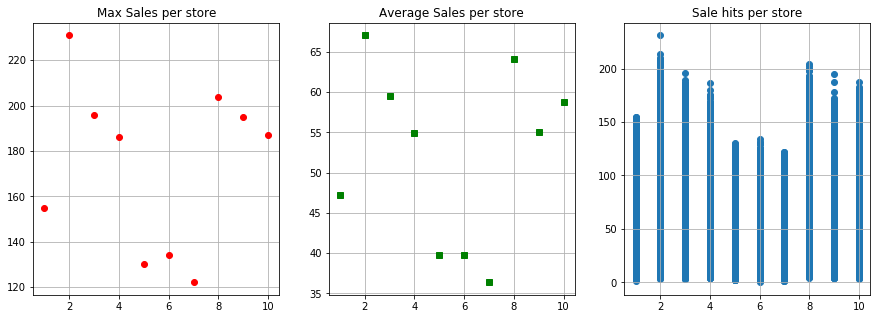

In [32]:
plt.figure(figsize=(15,5)) #(width,height)

plt.subplot(1,3,1) #(row,col,index_in_this_matrix)
store_sales = pd.pivot_table(train,index=['store'],values='sales',aggfunc=[np.max])
plt.grid()
#plt.grid(color='r', linestyle='-', linewidth=1)
plt.title("Max Sales per store")
plt.plot(store_sales, 'ro')

plt.subplot(1,3,2) #(row,col,index_in_this_matrix)
store_sales = pd.pivot_table(train,index=['store'],values='sales',aggfunc=[np.mean])
plt.grid()
plt.title("Average Sales per store")
plt.plot(store_sales, 'gs')

plt.subplot(1,3,3) #(row,col,index_in_this_matrix)
plt.grid()
plt.title("Sale hits per store")
plt.scatter(train.store,train.sales)

### Variation in scale of the sale transacted

C:\Users\szelee\Anaconda3\envs\fastai\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(array([1.32311355e-02, 7.93051797e-03, 1.41683697e-03, 6.73390259e-05,
        3.97671413e-07]),
 array([ 10,  50, 100, 150, 200, 250]),
 <a list of 5 Patch objects>)

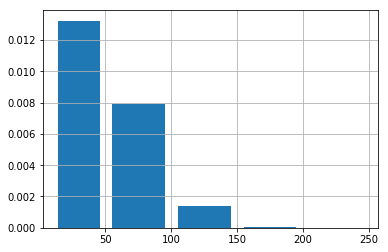

In [34]:
bins = [10, 50, 100, 150, 200, 250]
plt.grid()
plt.hist(train.sales, bins, normed=1, histtype='bar', rwidth=0.8)

### Store wise total and average sales

,sum,mean
,sales,sales
store,,
1,4315603,47.268379
2,6120128,67.033165
3,5435144,59.530602
4,5012639,54.902946
5,3631016,39.770164
6,3627670,39.733516
7,3320009,36.363735
8,5856169,64.142048



Max sum and mean sales of all


sum   sales    6.120128e+06
mean  sales    6.703317e+01
dtype: float64

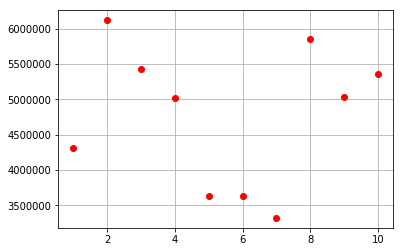

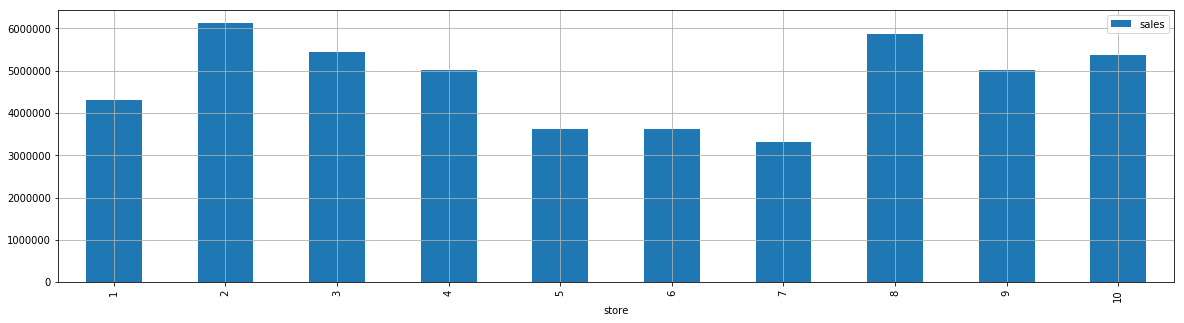

In [44]:
pivot_table_store_sales = pd.pivot_table(train,index=["store"],values=["sales"],aggfunc=[np.sum,np.mean])
display(pivot_table_store_sales)

print()
print('Max sum and mean sales of all')
display(pivot_table_store_sales.max(axis=0))

plt.grid()
plt.plot(pivot_table_store_sales["sum"], 'ro')

pivot_table_store_sales["sum"].plot(kind="bar",legend="Sum", figsize=(20,5)).grid()

### Item wise total and average sales

,sum,mean
,sales,sales
item,,
1,401384,21.981599
2,1069564,58.574151
3,669087,36.642223
4,401907,22.010241
5,335230,18.358708
6,1068281,58.503888
7,1068777,58.531051
8,1405108,76.950055


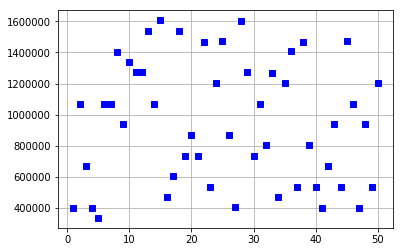

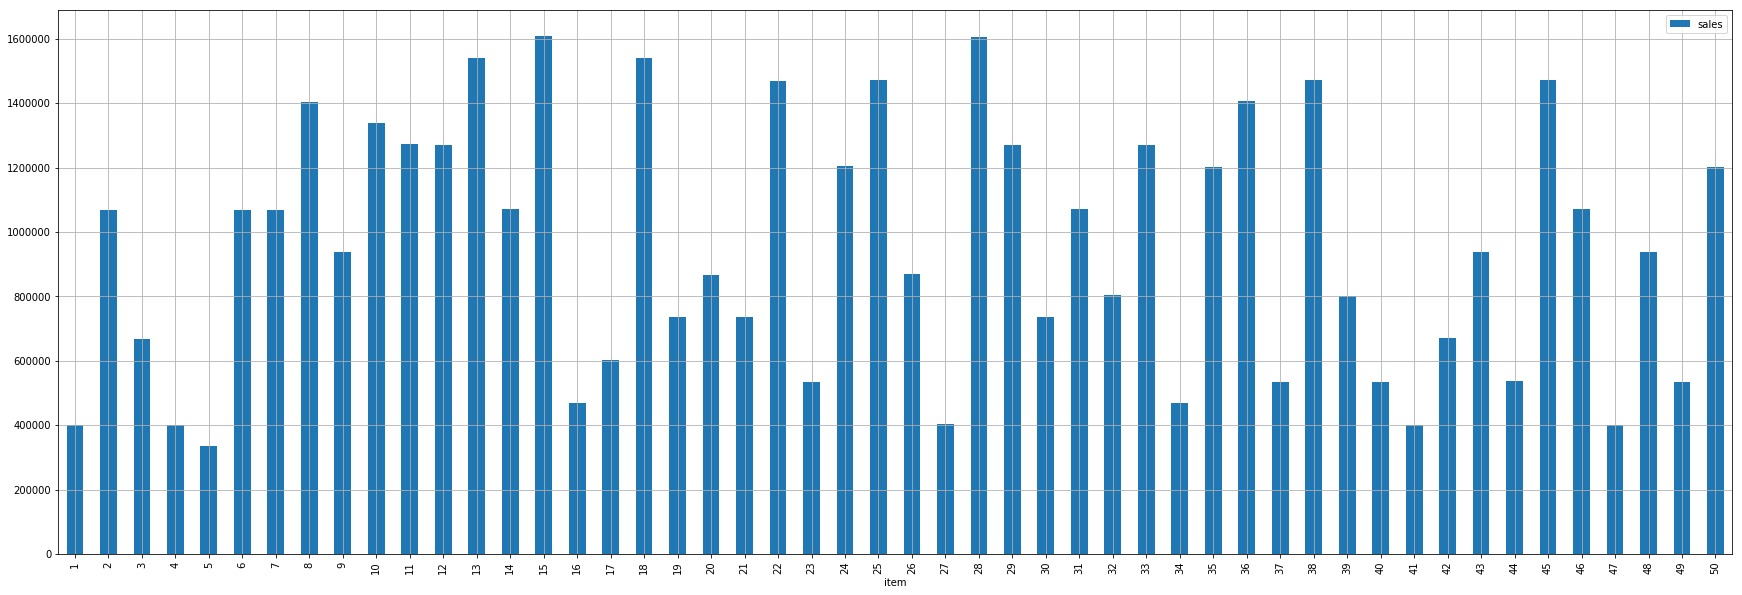

In [45]:
pivot_table_item_sales = pd.pivot_table(train,index=["item"],values=["sales"],aggfunc=[np.sum,np.mean])
display(pivot_table_item_sales.head(10))


plt.grid()
plt.plot(pivot_table_item_sales["sum"], 'bs')

pivot_table_item_sales["sum"].plot(kind="bar",legend="Sum", figsize=(30,10)).grid()

### Store's sales performance over time

In [52]:
time_plot_store_performance = pd.pivot_table(train,index=['date'],columns=['store',],values='sales',aggfunc=np.sum)
time_plot_store_performance.head()

store,1,2,3,4,5,6,7,8,9,10
date,,,,,,,,,,
2013-01-01,1316,1742,1588,1423,1032,1099,964,1628,1383,1521
2013-01-02,1264,1808,1538,1432,997,1023,944,1687,1455,1530
2013-01-03,1305,1887,1635,1534,1130,1149,966,1736,1492,1654
2013-01-04,1452,1983,1741,1685,1258,1201,1040,1966,1612,1739
2013-01-05,1499,2087,1887,1649,1154,1286,1131,2005,1698,1841


### Item's sales performance over time

In [53]:
time_plot_items_performance = pd.pivot_table(train,index=['date'],columns=['item',],values='sales',aggfunc=np.sum)
time_plot_items_performance.head()

item,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,133,327,172,102,83,288,278,416,245,378,...,103,195,253,154,396,319,116,277,159,330
2013-01-02,99,279,213,110,81,310,291,386,225,397,...,132,215,255,165,393,316,118,281,159,384
2013-01-03,127,304,193,112,96,309,324,398,265,388,...,131,215,306,170,459,325,104,280,187,356
2013-01-04,145,359,218,138,108,343,335,430,313,462,...,122,224,323,189,450,351,128,296,184,394
2013-01-05,149,377,217,144,100,343,377,481,319,449,...,142,243,309,202,533,360,133,344,179,407


### All store's performance

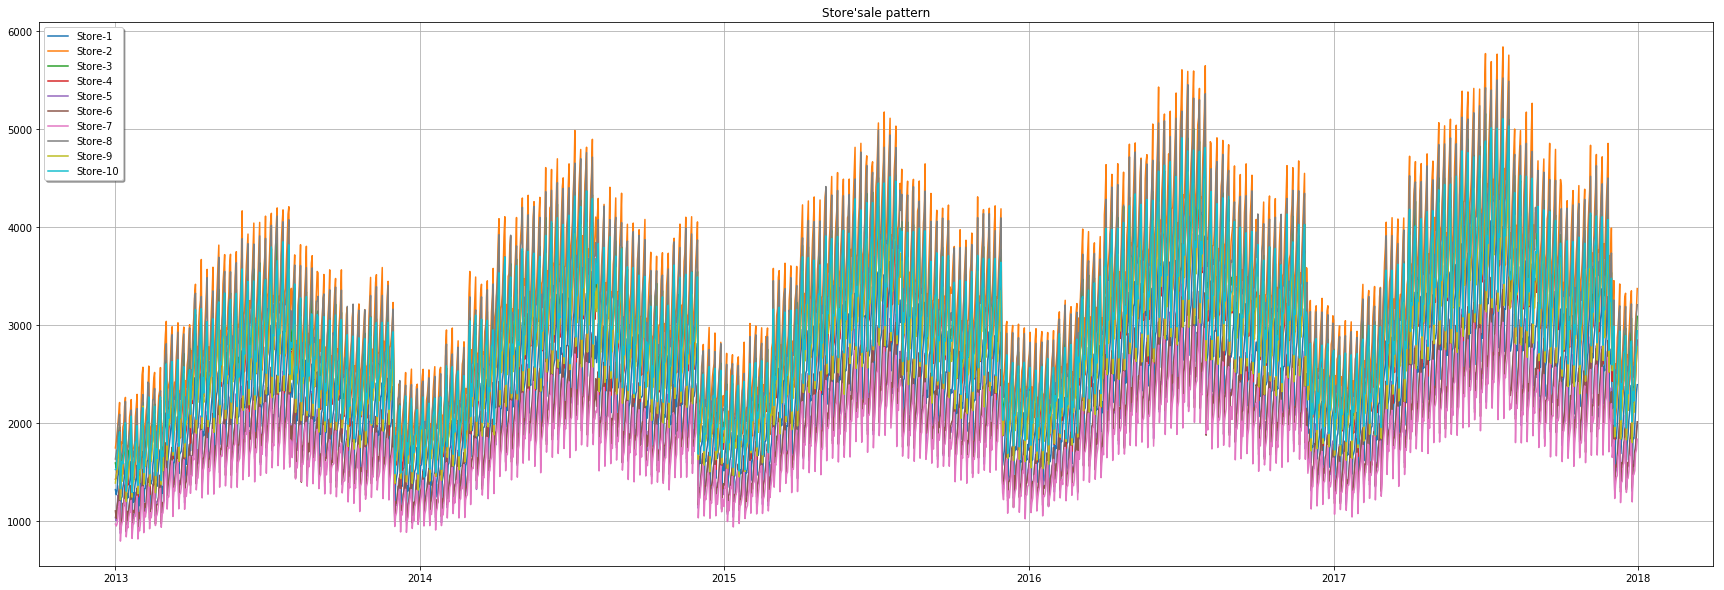

In [56]:
color_map = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
# for store in range(10):
#     performance_of_store = pd.pivot_table(train[df_train.store==(store+1)],index=['date'],columns=['store',],values='sales',aggfunc=np.sum)
#     plt.plot(performance_of_store, color=color_map[store])

plt.figure(figsize=(30,10)) #(width,height)
plt.title("Store'sale pattern")
plt.grid()
for store in range(10):
    performance_of_store = pd.pivot_table(train[train.store==(store+1)],index=['date'],columns=['store',],values='sales',aggfunc=np.sum)
    plt.plot(performance_of_store, color=color_map[store],label="Store-"+str(store+1))
plt.legend(loc='upper left', shadow=True)

### All item's performance

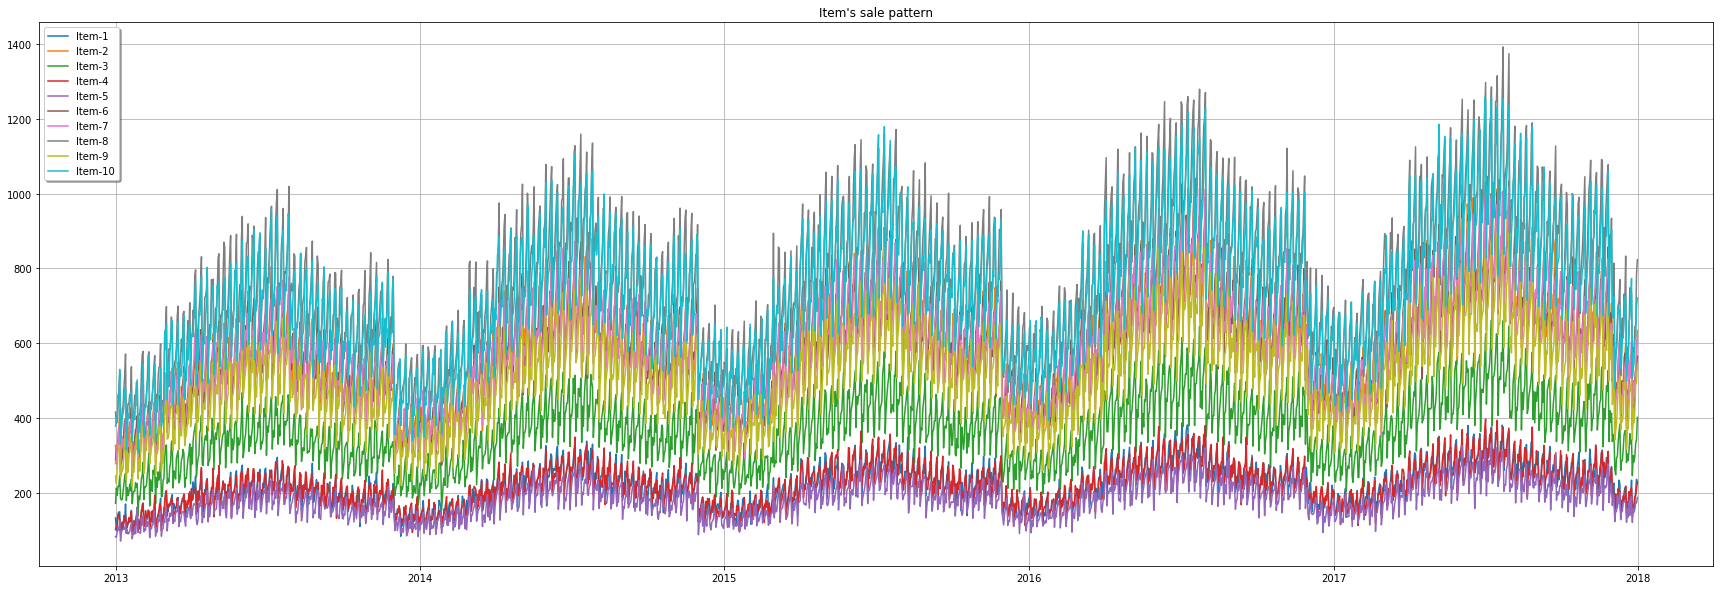

In [57]:
plt.figure(figsize=(30,10)) #(width,height)
plt.title("Item's sale pattern")
plt.grid()
for item in range(10): #For now lets look at 10 items
    performance_of_item = pd.pivot_table(train[train.item==(item+1)],index=['date'],columns=['item',],values='sales',aggfunc=np.sum)
    plt.plot(performance_of_item, color=color_map[item%10],label="Item-"+str(item+1))
plt.legend(loc='upper left', shadow=True)


### Individual pattern of store's sale

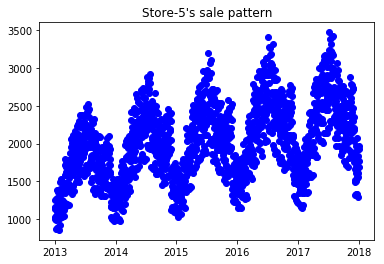

In [58]:
store_id = 5
sale_performance_of_store = pd.pivot_table(train[train.store==store_id],index=['date'],columns=['store',],values='sales',aggfunc=np.sum)
plt.title("Store-" + str(store_id) + "'s sale pattern")
plt.plot(sale_performance_of_store, 'bo',label="Store-"+str(store_id))

### Individual pattern of item's sale

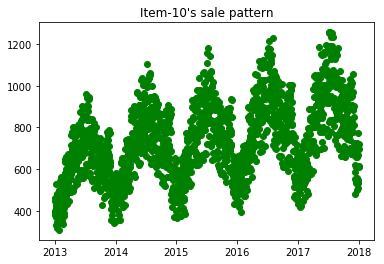

In [60]:
item_id = 10
sale_performance_of_item = pd.pivot_table(train[train.item==item_id],index=['date'],columns=['item',],values='sales',aggfunc=np.sum)
plt.title("Item-" + str(item_id) + "'s sale pattern")
plt.plot(sale_performance_of_item, 'go',label="Item-"+str(item_id))